# Prescriptive Analytics: Transportation Optimization
**Learning goals**
- Formulate a small transportation problem (2 DCs → 4 Stores).
- Minimize total cost under supply and demand constraints.
- Visualize the optimal shipping plan.

> Installs PuLP automatically; run all.


In [1]:
!pip -q install pulp

In [18]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import pulp

# Data
dcs = pd.DataFrame({"DC":["DC_East","DC_West"], "Supply":[610, 200]})
stores = pd.DataFrame({"Store":["Store_A","Store_B","Store_C","Store_D"], "Demand":[251,300,35,20]})
cost = pd.DataFrame({
    "DC":["DC_East","DC_West"],
    "Store_A":[4,6], "Store_B":[5,4], "Store_C":[7,3], "Store_D":[6,5]
})

# LP model
prob = pulp.LpProblem("Transportation", pulp.LpMinimize)
x = {(dc,st): pulp.LpVariable(f"x_{dc}_{st}", lowBound=0) for dc in dcs["DC"] for st in stores["Store"]}

# Objective
prob += pulp.lpSum(float(cost.loc[cost["DC"]==dc, st]) * x[(dc,st)]
                   for dc in dcs["DC"] for st in stores["Store"])

# Supply constraints
for _,row in dcs.iterrows():
    dc = row["DC"]
    prob += pulp.lpSum(x[(dc,st)] for st in stores["Store"]) <= row["Supply"], f"Supply_{dc}"

# Demand constraints
for _,row in stores.iterrows():
    st = row["Store"]
    prob += pulp.lpSum(x[(dc,st)] for dc in dcs["DC"]) == row["Demand"], f"Demand_{st}"

prob.solve(pulp.PULP_CBC_CMD(msg=False))
print(f"Status: {pulp.LpStatus[prob.status]}")
print(f"Min Cost (EUR): {pulp.value(prob.objective):.2f}")

rows=[]
for dc in dcs["DC"]:
    for st in stores["Store"]:
        qty = x[(dc,st)].value()
        if qty>0:
            rows.append((dc,st,qty))
res = pd.DataFrame(rows, columns=["DC","Store","Qty"])
res

Status: Optimal
Min Cost (EUR): 2564.00


/var/folders/y2/37476f0n7c793jplk1lghrkjr8cwhw/T/ipykernel_28798/2327648698.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  prob += pulp.lpSum(float(cost.loc[cost["DC"]==dc, st]) * x[(dc,st)]


,DC,Store,Qty
0,DC_East,Store_A,251.0
1,DC_East,Store_B,155.0
2,DC_West,Store_B,145.0
3,DC_West,Store_C,35.0
4,DC_West,Store_D,20.0


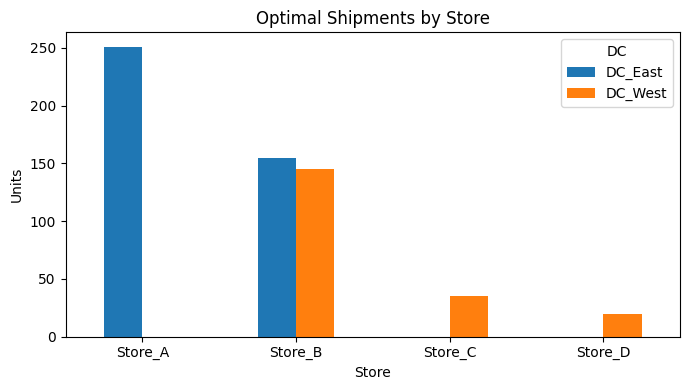

In [20]:
# Plot optimal shipments
pivot = res.pivot(index="Store", columns="DC", values="Qty").fillna(0)
pivot.plot(kind="bar", figsize=(7,4))
plt.title("Optimal Shipments by Store")
plt.xlabel("Store"); plt.ylabel("Units")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

**Discussion prompts**
- Which shipments are zero and why?
- If DC_East loses 100 units of capacity, how does the plan change?
